In [52]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from plotnine import *


# ADDRESS

In [37]:
meta_smile = pd.read_csv('meta_eGeMAPSv01b.csv')
meta_smile.head()

,Unnamed: 0,index,ID,Age,Gender,MMSE,Group,split,predict,predict_group
0,0,0,S001,74,male,30,cc,train,26.871142,cc
1,1,1,S002,62,female,30,cc,train,26.556385,cc
2,2,2,S003,69,female,29,cc,train,25.519604,cc
3,3,3,S004,71,female,30,cc,train,27.771522,cc
4,4,4,S005,74,female,30,cc,train,26.533502,cc


In [38]:
print(np.sqrt(mean_squared_error(meta_smile['MMSE'], meta_smile['predict'] )))

4.8916933197580414


In [41]:
meta_lstm = pd.read_csv('4-RollingWindow+LSTM+WN.csv')
meta_lstm.head()

,Unnamed: 0,index,ID,Age,Gender,MMSE,Group,split,predict,predict_group
0,0,0,S001,74,male,30,cc,train,26.442938,cc
1,1,1,S002,62,female,30,cc,train,26.371628,cc
2,2,2,S003,69,female,29,cc,train,23.839193,cd
3,3,3,S004,71,female,30,cc,train,26.750227,cc
4,4,4,S005,74,female,30,cc,train,23.580471,cd


In [40]:
print(np.sqrt(mean_squared_error(meta_lstm['MMSE'], meta_lstm['predict'] )))

6.008748657564505


In [75]:
meta_ensemble = pd.merge(meta_smile[['ID', 'Group', 'MMSE', 'predict']], 
                         meta_lstm[['ID', 'Group', 'split', 'predict']], 
                         on = ['ID', 'Group'], 
                         suffixes = ('_smile', '_lstm'))
meta_ensemble.head()

,ID,Group,MMSE,predict_smile,split,predict_lstm
0,S001,cc,30,26.871142,train,26.442938
1,S002,cc,30,26.556385,train,26.371628
2,S003,cc,29,25.519604,train,23.839193
3,S004,cc,30,27.771522,train,26.750227
4,S005,cc,30,26.533502,train,23.580471


In [76]:
meta_ensemble['predict_ensemble'] = .5 * meta_ensemble['predict_smile'] + .5 * meta_ensemble['predict_lstm']
meta_ensemble['predict_ensemble'].describe()


count    108.000000
mean      22.665130
std        3.169094
min        8.174403
25%       20.676663
50%       23.200161
75%       24.988859
max       27.260875
Name: predict_ensemble, dtype: float64

In [77]:
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
def cal_rmse(g):
    rmse_smile = np.sqrt(mean_squared_error(g['MMSE'], g['predict_smile']))
    rmse_lstm = np.sqrt(mean_squared_error(g['MMSE'], g['predict_lstm']))
    rmse_ensemble = np.sqrt(mean_squared_error(g['MMSE'], g['predict_ensemble']))

    return pd.Series(dict(rmse_smile = rmse_smile, 
                          rmse_lstm = rmse_lstm,
                          rmse_ensemble = rmse_ensemble))

meta_ensemble.groupby('split').apply(cal_rmse).reset_index()

,split,rmse_smile,rmse_lstm,rmse_ensemble
0,test,4.857964,6.025420,5.034664
1,train,4.866979,5.733340,4.832830
2,val,5.040692,7.144976,5.762146


In [78]:
cal_rmse(meta_ensemble)

rmse_smile       4.891693
rmse_lstm        6.008749
rmse_ensemble    5.012825
dtype: float64

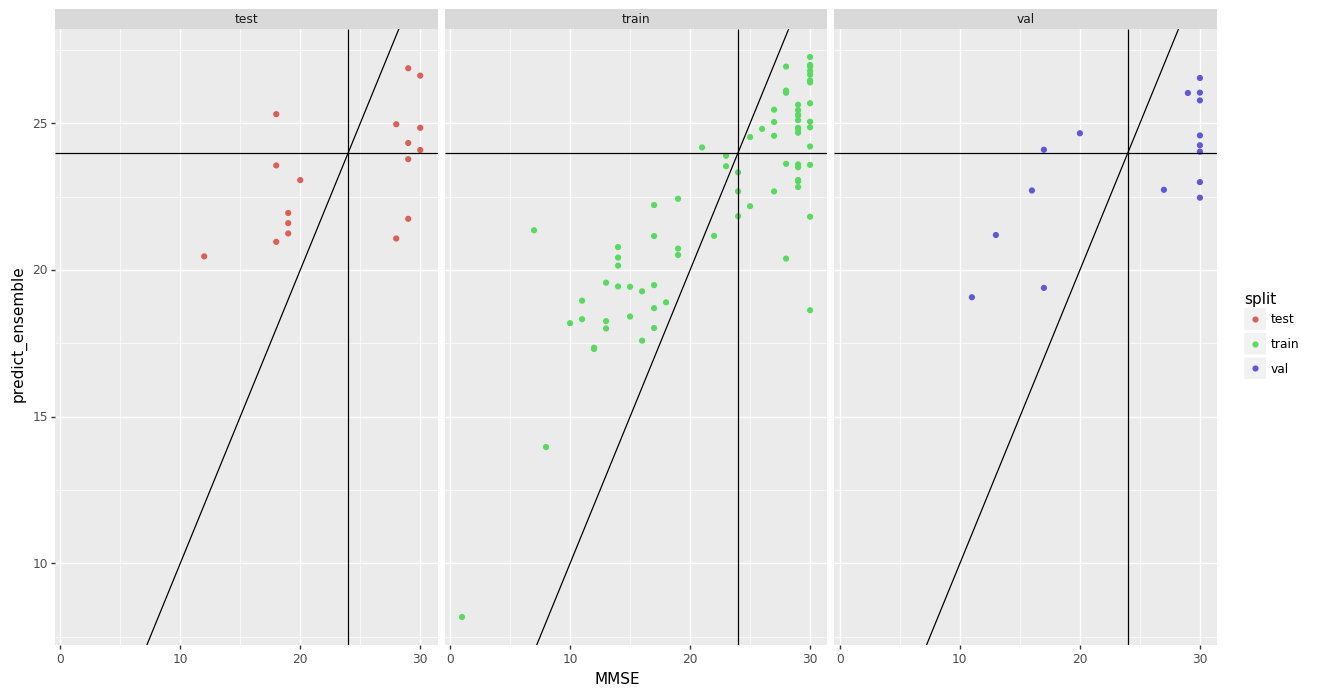

<ggplot: (8776001456034)>

In [71]:
ggplot(meta_ensemble) + \
geom_point(aes(x = 'MMSE', y = 'predict_ensemble', colour = 'split')) + \
facet_wrap('split', nrow = 1) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))

In [79]:
meta_ensemble['predict_ensemble_group'] = ['cc' if x >= 24 else 'cd' for x in meta_ensemble.predict_ensemble]
y_true = meta_ensemble.Group
y_pred = meta_ensemble.predict_ensemble_group
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          cc       0.84      0.70      0.77        54
          cd       0.75      0.87      0.80        54

    accuracy                           0.79       108
   macro avg       0.80      0.79      0.79       108
weighted avg       0.80      0.79      0.79       108



# Pitt Corpus

In [29]:
meta_pitt_smile = pd.read_csv('meta_pitt_eGeMAPSv01b.csv')
meta_pitt_smile.head()

,Unnamed: 0,file,ID,Group,MMSE,predict,predict_group
0,0,/tf/data/dementia/English/Pitt/Control/cookie/...,255-1,Control,28.0,17.759423,Dementia
1,0,/tf/data/dementia/English/Pitt/Control/cookie/...,056-3,Control,29.0,25.626785,Control
2,0,/tf/data/dementia/English/Pitt/Control/cookie/...,139-3,Control,30.0,15.066687,Dementia
3,0,/tf/data/dementia/English/Pitt/Control/cookie/...,210-2,Control,29.0,25.299405,Control
4,0,/tf/data/dementia/English/Pitt/Control/cookie/...,109-1,Control,30.0,26.835056,Control


In [30]:
meta_pitt_smile = meta_pitt_smile[meta_pitt_smile['MMSE'].notnull()]

print(np.sqrt(mean_squared_error(meta_pitt_smile['MMSE'], meta_pitt_smile['predict'] )))

7.944049228497729


In [26]:
meta_pitt_lstm = pd.read_csv('4-RollingWindow+LSTM+WN-pitt.csv')
meta_pitt_lstm.head()
meta_pitt_lstm = meta_pitt_lstm[meta_pitt_lstm['MMSE'].notnull()]

print(np.sqrt(mean_squared_error(meta_pitt_lstm['MMSE'], meta_pitt_lstm['predict'] )))

6.2860519836257875


In [31]:
meta_pitt_ensemble = pd.merge(meta_pitt_smile[['ID', 'Group', 'MMSE', 'predict']], 
                              meta_pitt_lstm[['ID', 'Group', 'predict']], 
                              on = ['ID', 'Group'], 
                              suffixes = ('_smile', '_lstm'))
meta_pitt_ensemble.head()

,ID,Group,MMSE,predict_smile,predict_lstm
0,255-1,Control,28.0,17.759423,26.444284
1,056-3,Control,29.0,25.626785,25.113256
2,139-3,Control,30.0,15.066687,23.186214
3,210-2,Control,29.0,25.299405,26.462302
4,109-1,Control,30.0,26.835056,24.406082


In [34]:
meta_pitt_ensemble['predict_ensemble'] = .5 * meta_pitt_ensemble['predict_smile'] + .5 * meta_pitt_ensemble['predict_lstm']
meta_pitt_ensemble['predict_ensemble'].describe()


count    457.000000
mean      23.009577
std        2.873090
min       12.741621
25%       21.095128
50%       23.180491
75%       25.178343
max       28.397079
Name: predict_ensemble, dtype: float64

In [36]:
print(np.sqrt(mean_squared_error(meta_pitt_ensemble['MMSE'], meta_pitt_ensemble['predict_ensemble'] )))

6.57998360609221
